# 08-Bidiretional LSTM with Attention versus Logistic Regression baseline


In [180]:
# Import code from file in upper directory
import sys, os
sys.path.append(os.getcwd() + os.sep + os.pardir)

#from tweet_data import *
from attn_lstm import AttentionBiLSTMClassifier
from train import load_model
from evaluate import predict_dataset
from tweet_data_old import *

from collections import Counter
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn import linear_model
from sklearn import metrics
from sklearn.externals import joblib

import matplotlib.pyplot as plt
import pandas as pd

# Bidirectional LSTM with attention

We start by instantiating a model with empty embeddings, and then loading the weights from an already trained model.

In [26]:
embeddings = np.empty((10002, 300), dtype=np.float32)
model = AttentionBiLSTMClassifier(embeddings)
model = load_model(model, '../runs/attbilstm-Sep28_14-29-40_gpu-deep-learner/best-ckpt.pt')

Load serialized dataset to evaluate the model:

In [3]:
test_set = TweetsBaseDataset.load('../data/test/us_test.set')

Loaded dataset with 50000 tweets, 10002 unique tokens


Since the model makes predictions for padded sequences in mini-batches, where sequences are sorted by length, the order can differ from the order of the tweets in the original dataset, so when predicting we also retrieve the indices that correspond to the line number of the tweet in the original dataset.

In [71]:
y_true, y_pred, indices = predict_dataset(model, test_set)

In [73]:
train_set = TweetsBaseDataset.load('../data/train/us_train.set')

In [74]:
id_to_emoji = get_mapping('../data/mapping/us_mapping.txt')
ids = list(id_to_emoji.keys())
counter = Counter(train_set.labels)
scores = pd.DataFrame(list(id_to_emoji.values()), columns=['emoji'])
scores['count'] = [counter[i] for i in id_to_emoji]

# Add metrics
for i, metric in enumerate(metrics):
    scores[metric.__name__] = metric(y_true, y_pred, average=None)
    
scores = scores.sort_values(by='count', axis=0, ascending=False)

In [91]:
max_failures = 5
all_failures = [[] for i in ids]
predictions = [[] for i in ids]
inverse_vocab = {idx: word for word, idx in train_set.vocabulary.items()}
failure_indices_attbilstm = []

for i, y in enumerate(y_true):
    
    if sum([len(failures) for failures in all_failures]) == max_failures * len(ids):
        break
    
    if len(all_failures[y]) < max_failures and y != y_pred[i]:
        failure_indices_attbilstm.append(indices[i])
        text_ids, _, _ = test_set[indices[i]]
        text_ids = text_ids.data.numpy()
        text = " ".join([inverse_vocab[idx] for idx in text_ids])
        
        all_failures[y].append(text)
        predictions[y].append(y_pred[i])
        
for i, failures in enumerate(all_failures):
    print('Target Emoji: {}'.format(id_to_emoji[i]))
    for j, fail in enumerate(failures):
        print('\t' + fail)
        print('\tPredicted: {}\n'.format(id_to_emoji[predictions[i][j]]))
    print('-'*100)

Target Emoji: ❤
	<hashtag> <UNK> </hashtag> <hashtag> <UNK> </hashtag> <hashtag> morning light </hashtag> <hashtag> beach walk </hashtag> <hashtag> ocean love </hashtag> <hashtag> nh <UNK> </hashtag> @ the wall , north beach , …
	Predicted: 😎

	- gains and more gains , i ’ m on to something . - <allcaps> b o o k </allcaps> your time with me , come get you …
	Predicted: 😜

	it ' s the weekend , stay for a while . <repeated> <hashtag> new wave </hashtag> <hashtag> mind over matter </hashtag> <hashtag> luxury </hashtag> <hashtag> la living </hashtag> …
	Predicted: 😎

	almost <time> , still dark af out , but what is this sky ? ! <repeated> { <hashtag> nyc </hashtag> <hashtag> good morning </hashtag> <hashtag> early mornings </hashtag> …
	Predicted: 😍

	about to <UNK> into tuesday . <hashtag> jeep </hashtag> <hashtag> jeep wave </hashtag> <hashtag> jeep life </hashtag> <hashtag> <UNK> </hashtag> <hashtag> jeep nation </hashtag> <hashtag> jeep porn </hashtag> …
	Predicted: 😎

---------------

# Logistic regression baseline 

First, we are going to fit the model with the best parameters found during grid search.

In [27]:
log_reg_model = linear_model.LogisticRegression(max_iter = 30, penalty='l1', random_state = 42, tol=0.1, solver = 'saga')

In [110]:
# Load train and test dataset and labels
train_set_BOW = TweetsBOWDataset('../data/train/','us_train')
test_set_BOW = TweetsBOWDataset('../data/test/','us_test')

Reading files in directory ../data/train/us_train
Read file with 489609 tweets
Building vocabulary
Loading labels
Loading counts matrix
Creating TF-ID matrix
Reading files in directory ../data/test/us_test
Read file with 50000 tweets
Building vocabulary
Loading labels
Loading counts matrix
Creating TF-ID matrix


In [111]:
# Get predicted emojis for the test set
log_reg = log_reg_model.fit(train_set_BOW.data, train_set_BOW.labels)

# Error Analysis

In [159]:
# Lets plot the confusion matrix for the logistic regression ...

In [158]:
y_pred_log_reg = log_reg.predict(test_set_BOW.data)

In [150]:
cm = metrics.confusion_matrix(test_set_BOW.labels, y_pred_log_reg)

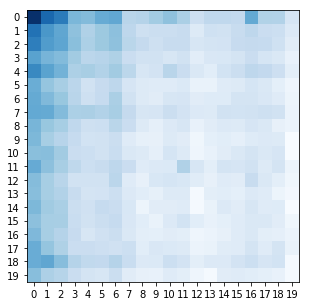

In [153]:
plt.figure(figsize=(5,5))
plt.imshow(cm**0.3, cmap='Blues')
plt.xticks(ids);
plt.yticks(ids);

- boxes in the left of the plot contain higher values than on the right
- logistic regression can not cope well with unbalanced dataset, biased towards classes which appear more frequently in the training set
- emojis of almost all classes are misclassified as the most frequent one (❤) 
- however, most frequent emoji less frequently misclassified than other emojis

Other peculiarities:
- Emoji 😁(16) often confused with most frequent emoji ❤ (0)
- in general, bad performance can be seen as diagonal does not contain high values


# Failure Analysis on specific examples
# Att. bi-LSTM vs. Logistic regression

In [185]:
# Check where the logistic regression succeeds to predict the correct  
# emoji where the bidirectional LSTM with attention fails
success_logreg = [] 
inverse_vocab = {idx: word for word, idx in train_set.vocabulary.items()}

for i, tweet_idx in enumerate(failure_indices_attbilstm):
    y_pred_log_reg = log_reg.predict(test_set_BOW.data[tweet_idx].reshape(1,-1))
    if y_pred_log_reg != test_set_BOW.labels[tweet_idx]:
        # Log reg. also failing at those examples...
        pass
    else:
        # Log reg. succeeds where bi-LSTM with attention fails
        # Get Tweet
        text_ids = test_set_BOW[tweet_idx][0]
        text_ids = text_ids.numpy()
        tweet = " ".join([inverse_vocab[idx] for idx in text_ids])
        
        
        print('Log reg. succeeds where bi-LSTM with attention fails:')
        print('Target Emoji: {}'.format(id_to_emoji[int(y_pred_log_reg)]))
        print('Logreg Emoji: {}'.format(id_to_emoji[int(y_pred_log_reg)]))

        print('\t' + 'TWEET:')
        print('\t' + tweet)
        print('-'*100)

Log reg. succeeds where bi-LSTM with attention fails:
Emoji: ❤
	TWEET:
	biscuit <number> off </allcaps> do the a of my mouth here ) back s ️ a ! ! ! <hashtag> home liam food </hashtag> <hashtag> day . date </hashtag> …
----------------------------------------------------------------------------------------------------
Log reg. succeeds where bi-LSTM with attention fails:
Emoji: ❤
	TWEET:
	with it texas day paradise ️ <hashtag> dallas join </hashtag> <hashtag> <UNK> </hashtag> <hashtag> bass </hashtag> <hashtag> chosen </hashtag> <hashtag> chapter </hashtag> <hashtag> fireplace </hashtag> <hashtag> lovely </hashtag> …
----------------------------------------------------------------------------------------------------
Log reg. succeeds where bi-LSTM with attention fails:
Emoji: 😍
	TWEET:
	making atlanta half <hashtag> making </hashtag> <hashtag> stadium okay </hashtag> <hashtag> hershey half </hashtag> <hashtag> statue field </hashtag> <hashtag> green </hashtag> <hashtag> atlanta </hasht

In 8 out of 100 failure cases of the bi-LSTM with attention the logistic regression is able to specifiy the correct emoji. For 4 out of these 8 tweets the heart emoji ❤ (which is the most frequent one) was the ground truth label. 